In [87]:
# Classification
import math
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling1D, Conv1D, GlobalMaxPooling1D, BatchNormalization
from keras.layers import Dense
from keras.regularizers import L1L2
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses, regularizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, confusion_matrix, auc
from sklearn.metrics import roc_auc_score, precision_recall_curve
import pandas as pd
import time
import os


In [52]:
#Best performing architect
# CM: [39 2 4 29]
# Accuracy: 0.919
# Sensitivity: 0.879
# Specificity: 0.951
# MCC: 0.836

# def create_model():
#     # Create model
#     model = Sequential()
#     model.add(Conv1D(filters=32, kernel_size=14, strides=1, activation='relu', input_shape=[None,1], name = 'L1'))
#     model.add(tf.keras.layers.Dropout(0.2)),  # dropout rate of 0.2
#     model.add(Conv1D(filters=32, kernel_size=4, strides=1, activation='relu', name = 'L2'))  # New Conv1D layer
#     #model.add(Conv1D(filters=16, kernel_size=3, strides=1, activation='relu', name = 'L3'))  # New Conv1D layer
#     model.add(GlobalAveragePooling1D())
#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(1, activation='sigmoid', name='classification'))
#     # Compile model
#     adam = tf.keras.optimizers.Adam(learning_rate=1.e-04)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     #model.summary()
#     return model

# model with acc = 91% for 1dcnn selected features:==>
# def create_model():
#     # Create model
#     model = Sequential()
#     model.add(Conv1D(filters=64, kernel_size=7, strides=1, activation='relu',padding = 'valid', input_shape=[None,1], name = 'L1'))
#     model.add(tf.keras.layers.Dropout(0.4)),  # dropout rate of 0.4
#     model.add(BatchNormalization())
#     model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', name = 'L2'))
#     model.add(Conv1D(filters=32, kernel_size=1, strides=1, activation='relu', name = 'L3'))  # New Conv1D layer
#     model.add(Conv1D(filters=16, kernel_size=1, strides=1, activation='relu', name = 'L4'))  # New Conv1D layer
#     model.add(GlobalAveragePooling1D())
#     model.add(tf.keras.layers.Dropout(0.4)),  # dropout rate of 0.4
#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(1, activation='sigmoid', name='classification'))
#     # Compile model
#     adam = tf.keras.optimizers.Adam(learning_rate=1.e-04)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     #model.summary()
#     return model


In [53]:
## Best model 06252024
# folds = 5
# batch_sz = 16
# dropout = 0.6
# kernel_sz = 14
# num_filters = 112 #128 #64
# ## Function to create model, required for KerasClassifier
# def create_model():
#     # Create model
#     model = Sequential()
#     model.add(Conv1D(filters=num_filters, kernel_size=kernel_sz, strides=1, activation='relu', input_shape=[None,1], name = 'L1'))
#     model.add(tf.keras.layers.Dropout(dropout))  # dropout rate of 0.4
#     model.add(Conv1D(filters=num_filters, kernel_size=6, strides=1, activation='relu', name = 'L2'))
#     model.add(Conv1D(filters=32, kernel_size=1, strides=1, activation='relu', name = 'L3'))
#     #model.add(Conv1D(filters=16, kernel_size=1, strides=1, activation='relu', name = 'L4'))  # New Conv1D layer
#     model.add(GlobalAveragePooling1D())
#     model.add(tf.keras.layers.Dropout(dropout))  # dropout rate of 0.4
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(1, activation='sigmoid', name='classification'))
#     # Compile model
#     adam = tf.keras.optimizers.Adam(learning_rate=1.e-04)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     #model.summary()
#     return model

In [54]:
# copy of Rahul's model
# def create_model():
#     # Create model
#     model = Sequential()
#     model.add(Conv1D(filters=14, kernel_size=10, strides=1, activation='relu', input_shape=[None,1]))
#     model.add(GlobalAveragePooling1D())
#     model.add(Dense(1, activation='sigmoid', name='classification'))
#     # Compile model
#     adam = tf.keras.optimizers.Adam(lr=1.e-04)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     #model.summary()
#     return model

In [124]:
def normalize(data):
  min = np.min(data,axis = 0)
  max = np.max(data,axis = 0)
  #print('min, max',min, max)
  data =  (data-min)/(max-min)
  return data

# Fix random seed for reproducibility
seed = 128
np.random.seed(seed)
# Split into input (X) and output (y) variables
#data = pd.read_csv(r'../content/exp_nov_winSiz_5T123ST2_selectedConn.csv').values
#dir = r'C:\Users\kamata3\Work\Brain\Brain_network\EEG_fNIRS_paper_Brain_informatics\fNIRS_codes_results\Connectivities_LSTMED_multiChanROI'  # directory of connectivities
#filename = 'exp_nov_winSiz_5T123ST13.csv'

dir = r'C:\Users\_Kamat_\Desktop\RPI\ResearchWork\Papers_\Effective_Connectivity\EEG_fNIRS_paper_Brain_informatics\channelEEG_codes_results_alphaBand\Results\Connectivities_LSTMED_multiChanROI_Copy'  # directory of connectivities
#filename = 'exp_nov_winSiz_5ST13_Copy.csv'
filename = 'exp_nov_winSiz_5P4_Copy.csv'

data = pd.read_csv(os.path.join(dir,filename)).values
m,n = data.shape
X0 = normalize(data[:,0:n-1])

print(X0.shape)
X = X0.reshape(X0.shape[0],X0.shape[1],1)
X = normalize(X)

print(X.shape)
y = data[:,n-1]
y = np.array([0 if y[i]==-1 else 1 for i in range(len(y))])
print(y.shape)

(43, 20)
(43, 20, 1)
(43,)


In [129]:
best_model = {'accuracy': 0, 'sensitivity': 0, 'specificity': 0, 'MCC': 0, 'model': None}
# classifier
folds = 5
batch_sz = 16
dropout = 0.6
# kernel_szL1 = [14,13,12,11,10,9,8,7,6,5,4,3]
# kernel_szL2 = [3,4,5,6,7,8,9,10,11,12,13,14]
# filters = [32,64,128]

kernel_szL1 = [9]#[14,13,11,9,7,5] #
kernel_szL2 = [7] #[7,9,11,13,14] #
filters = [128]#[32,64,128] #
## Function to create model, required for KerasClassifier
start_time = time.time()
accuracy_temp = 0
for kernel_sz1 in kernel_szL1:
  for kernel_sz2 in kernel_szL2:
    if 21-kernel_sz1 > kernel_sz2:
      for filter_sz in filters:
        print(f'working on Kernel_sz1_{kernel_sz1}, Kernel_sz2_{kernel_sz2}, filter_size{filter_sz}')
        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=filter_sz, kernel_size=kernel_sz1, strides=1, activation='relu', input_shape=[None,1], name = 'L1'))
            model.add(tf.keras.layers.Dropout(dropout))  # dropout rate of 0.4
            model.add(Conv1D(filters=filter_sz, kernel_size=kernel_sz2, strides=1, activation='relu', name = 'L2'))
            model.add(Conv1D(filters=32, kernel_size=1, strides=1, activation='relu', name = 'L3'))
            #model.add(Conv1D(filters=16, kernel_size=1, strides=1, activation='relu', name = 'L4'))  # New Conv1D layer
            model.add(GlobalAveragePooling1D())
            model.add(tf.keras.layers.Dropout(dropout))  # dropout rate of 0.4 or 0.6
            model.add(Dense(64, activation='relu'))
            model.add(Dense(32, activation='relu'))
            model.add(Dense(1, activation='sigmoid', name='classification'))
            # Compile model
            adam = tf.keras.optimizers.Adam(learning_rate=1.e-04)
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            #model.summary()
            return model
        #classifier = create_model() # KerasClassifier(build_fn=create_model, epochs=2000, batch_size=5, verbose=0)
        #classifier.summary()

        y_true = []
        y_pred = []
        itest = []
        kf = StratifiedKFold(n_splits=folds, shuffle=False)
        #kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
        for train, test in kf.split(X,y):
            x_train, x_test, y_train, y_test = X[train], X[test], y[train], y[test]
            #print(x_test[:,0])
            # print(y_test)
            classifier = create_model() #KerasClassifier(build_fn=create_model, epochs=2000, batch_size=5, verbose=0)
            es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=200, restore_best_weights = True)
            # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
            #                          patience=5, min_lr=0.00001)
            classifier.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5000, batch_size=batch_sz, shuffle=False, verbose=0, callbacks=[es]) #, callbacks=[es, reduce_lr], epochs=5000
            # Predicting the Test set results
            k_pred = classifier.predict(x_test)
            y_true = np.append(y_true, y_test)
            y_pred = np.append(y_pred, k_pred)
            itest = np.append(itest, test)

        # ROC and AUC
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        area = auc(fpr, tpr)

        # calculate the g-mean for each threshold
        gmeans = np.sqrt(tpr * (1-fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        # Making the Confusion Matrix [tn, fp, fn, tp]
        tn, fp, fn, tp = confusion_matrix(y_true, (y_pred >= thresholds[ix])).ravel()
        N = tn+fp+fn+tp
        S = (tp+fn)/N
        P = (tp+fp)/N
        MCC = ((tp/N)-S*P)/np.sqrt(P*S*(1.-S)*(1.-P))
        accuracy = (tp+tn)/(tn+fp+fn+tp)
        print(f'accuracy: {accuracy}')
        sensitivity = (tp)/(tp+fn)
        specificity = (tn)/(tn+fp)
        if accuracy > accuracy_temp:
          accuracy_temp = accuracy
          best_model['accuracy'] = accuracy
          best_model['sensitivity'] = sensitivity
          best_model['specificity'] = specificity
          best_model['MCC'] = MCC
          best_model['model'] = classifier
          best_model['y_true'] = y_true
          best_model['y_pred'] = y_pred
          best_model['itest'] = itest
          best_model['fpr'] = fpr
          best_model['tpr'] = tpr
          best_model['thresholds'] = thresholds
          best_model['ix'] = ix
          best_model['area'] = area
          best_model['tn'] = tn
          best_model['fp'] = fp
          best_model['fn'] = fn
          best_model['tp'] = tp

          ind = []
          count_one = 2
          count_zero = 2
          for label in y_true:
              if label > 0:
                ind.append(count_one)
                count_one+=1
              else: 
                ind.append(count_zero)
                count_zero +=1
          True_pred = np.vstack((ind,y_true,y_pred>= thresholds[ix])).T
          print(True_pred)
end_time = time.time()
print(f"Training time: {(end_time-start_time)/60} minutes")

working on Kernel_sz1_9, Kernel_sz2_7, filter_size128


c:\Users\_Kamat_\Desktop\RPI\ResearchWork\Papers_\Effective_Connectivity\tfLSTM_ED\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
accuracy: 0.9069767441860465
[[ 2.  1.  0.]
 [ 3.  1.  1.]
 [ 4.  1.  1.]
 [ 5.  1.  1.]
 [ 2.  0.  0.]
 [ 3.  0.  0.]
 [ 4.  0.  0.]
 [ 5.  0.  0.]
 [ 6.  0.  0.]
 [ 6.  1.  1.]
 [ 7.  1.  1.]
 [ 8.  1.  1.]
 [ 9.  1.  1.]
 [ 7.  0.  0.]
 [ 8.  0.  0.]
 [ 9.  0.  0.]
 [10.  0.  1.]
 [11.  0.  0.]
 [10.  1.  1.]
 [11.  1.  0.]
 [12.  1.  0.]
 [12.  0.  0.]
 [13.  0.  0.]
 [14.  0.  0.]
 [15.  0.  0.]
 [16.  0.  0.]
 [17.  0.  0.]
 [13.  1.  1.]
 [14.  1.  1.]
 [15.  1.  1.]
 [18.  0.  0.]
 [19.  0.  0.]
 [20.  0.  0.]
 [21.  0.  0.]
 [22.  0.  0.]
 [16.  1.  1.]
 [17.  1.  1.]
 [18.  1.  1.]
 [23.  0.  0.]
 [24.  0.  0.]
 [25.  0.  0.]
 [26.  0.  0.]
 [27.  0.  0.]]
Training time: 4.342974305152893 minutes


In [130]:
#best_model['model'].summary()
#print("Best model's hyperparameters and configuration:")
# print(best_model['model'].get_config())
#print(best_model['model'].get_config()['layers'])
layers_config = best_model['model'].get_config()['layers']
layers_df = pd.DataFrame([layer['config'] for layer in layers_config])
file_name = f"TrainReport_{filename.rstrip('.csv')}.xlsx"
#layers_df.to_excel(file_name, index=False)
#directory = r'C:\Users\kamata3\Work\Brain\Brain_network\EEG_fNIRS_paper_Brain_informatics\fNIRS_codes_results\Results_1DCNN_LSTMED_mulitChannelROI' 

directory = r'C:\Users\_Kamat_\Desktop\RPI\ResearchWork\Papers_\Effective_Connectivity\EEG_fNIRS_paper_Brain_informatics\channelEEG_codes_results_alphaBand\Results\temp'
file_path = os.path.join(directory, file_name)

# Create DataFrames for additional data
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'MCC', 'AUC', 'TP', 'FP', 'TN', 'FN'],
    'Value': [best_model['accuracy'], best_model['sensitivity'], best_model['specificity'], best_model['MCC'], best_model['area'], best_model['tp'], best_model['fp'], best_model['tn'], best_model['fn']]
})

roc_df = pd.DataFrame({
    'FPR': best_model['fpr'],
    'TPR': best_model['tpr'],
    'Thresholds': best_model['thresholds']
})

predictions_df = pd.DataFrame({
    'y_true': best_model['y_true'],
    'y_pred': best_model['y_pred'],
    'itest': best_model['itest']
})

with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
    layers_df.to_excel(writer, sheet_name='Model Configuration', index=False)
    metrics_df.to_excel(writer, sheet_name='Metrics', index=False)
    roc_df.to_excel(writer, sheet_name='ROC Curve', index=False)
    predictions_df.to_excel(writer, sheet_name='Predictions', index=False)

Best Threshold=0.418573, G-Mean=0.890


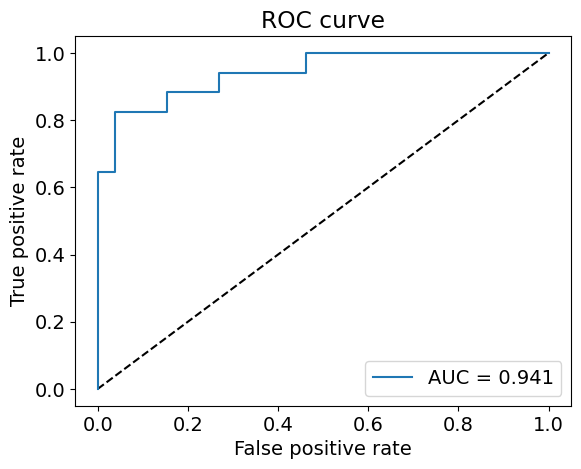

Best Threshold=0.418573, F-Score=0.875


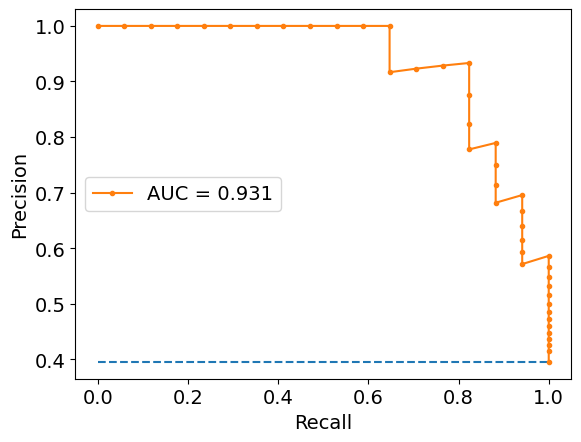

CM: [25 1 3 14]
Accuracy: 0.907
Sensitivity: 0.824
Specificity: 0.962
MCC: 0.805


In [131]:
# ROC and AUC
y_true = best_model['y_true']
y_pred = best_model['y_pred']

fpr = best_model['fpr']
tpr = best_model['tpr']
thresholds = best_model['thresholds']

# calculate roc curves
area = auc(fpr, tpr)
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(area))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
area = auc(recall, precision)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# plot the roc curve for the model
plt.figure()
no_skill = len(y_true[y_true==1]) / len(y_true)
plt.plot([0,1], [no_skill,no_skill], linestyle='--')
plt.plot(recall, precision, marker='.', label='AUC = {:.3f}'.format(area))
#plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

# Making the Confusion Matrix [tn, fp, fn, tp]
tn = best_model['tn']
fp = best_model['fp']
fn = best_model['fn']
tp = best_model['tp']

#tn, fp, fn, tp = confusion_matrix(y_true, (y_pred >= thresholds[ix])).ravel()
N = tn+fp+fn+tp
S = (tp+fn)/N
P = (tp+fp)/N
#MCC = ((tp/N)-S*P)/np.sqrt(P*S*(1.-S)*(1.-P))
MCC = best_model['MCC']
accuracy = best_model['accuracy']
sensitivity = best_model['sensitivity']
specificity = best_model['specificity']

print("CM: [%d %d %d %d]" %(tn, fp, fn, tp))
print("Accuracy: %0.3f" %(accuracy))
print("Sensitivity: %0.3f" %(sensitivity))
print("Specificity: %0.3f" %(specificity))
print("MCC: %0.3f" %(MCC))


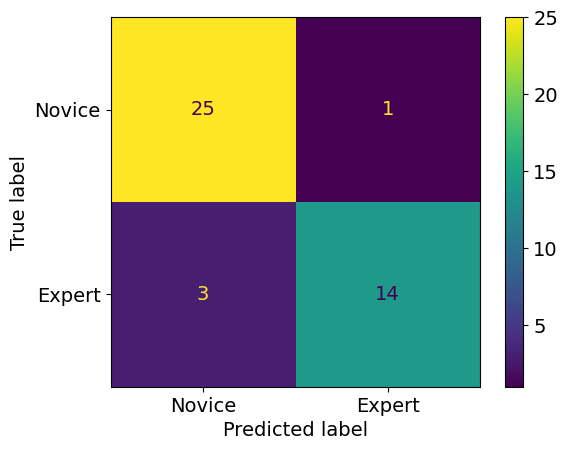

In [132]:
from matplotlib import rcParams
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#rcParams['font.sans-serif'] = ['calibri']  # You can change 'Arial' to any other desired font
rcParams['font.size'] = 14
# from sklearn.metrics import plot_confusion_matrix, confusion_matrix
conf_matrix = np.array([[tn, fp],
               [fn, tp]])
#conf_matrix =confusion_matrix(y_true, (y_pred >= thresholds[ix]))
# Plot the confusion matrix
labels = ['Novice', 'Expert']
# plot_confusion_matrix(conf_matrix, display_labels=labels, cmap=plt.cm.Blues, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=labels)
disp.plot()
plt.show()